# Import libraries and files

In [ ]:
import numpy as np
import nibabel.processing as nibp
import os
import nibabel as nib
import math
import random
import sklearn.preprocessing
import matplotlib.pyplot as plt
from numpy import random
from numpy import savetxt
from sklearn.metrics import mean_squared_error
from torch.utils.data import random_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
random.seed(42)

In [ ]:
class Scaler():
    ## used to normalize sequences
    def __init__(self,inputs):
        self.data = inputs
        self.mean = np.mean(inputs,axis=1)
        self.std = np.std(inputs, axis=1)
        self.vox, self.time = inputs.shape
    def transform(self,inputs):
        self.mean = np.reshape(self.mean,(self.vox,1))
        self.m_large = np.repeat(self.mean,self.time,axis=1)
        self.std = np.reshape(self.std,(self.vox,1))
        self.s_large = np.repeat(self.std,self.time,axis=1)
        return np.divide(inputs-self.m_large,self.s_large)
    def inverse_transform(self,outputs):
        return np.multiply(outputs,self.s_large)+self.m_large

In [ ]:
def create_signal():
    ### functions to generate noise and signal separately as a sine function with noise, and noise and signal has different range of b's
    a_n = random.uniform(5,10)
    b_n = random.uniform(0.1,1)
    c_n = random.uniform(200,300)
    y_n = np.array([a_n*np.sin(i*b_n)+c_n+0.01*random.randint(-100,100) for i in range(156)])
    a_s = random.uniform(5,10)
    b_s = random.uniform(1,3)
    c_s = random.uniform(200,300)
    y_s = np.array([a_s*np.sin(i*b_s)+c_s+0.01*random.randint(-100,100) for i in range(156)])
    return [y_n, y_s]

In [ ]:
num_obs = 10000 #number of observations
ground_truth_list = np.zeros([num_obs, 156]) # initionalization of ground truths
observation_list = np.zeros([num_obs, 156]) # initionalization of observations
noise_list = np.zeros([num_obs, 156]) # initionalization of noises
# generation of noises and ground truths
for i in range(num_obs):
    [noise_list[i],ground_truth_list[i]] = create_signal()

In [ ]:
# subtracting means from noises and ground truths across each seqeunce
noise_list = noise_list - np.repeat(np.reshape(np.mean(noise_list,axis=1),(noise_list.shape[0],1)),noise_list.shape[1],axis=1)
ground_truth_list = ground_truth_list - np.repeat(np.reshape(np.mean(ground_truth_list,axis=1),(ground_truth_list.shape[0],1)),ground_truth_list.shape[1],axis=1)

In [ ]:
# normalize the grounth truth
gt_scale = Scaler(ground_truth_list)
gt_list = gt_scale.transform(ground_truth_list)

In [ ]:
# # linear combination of noise and ground truth, leading to the observations, and standard deviation is arbitrary
# std = 2
# lamb = math.sqrt(std**2/noise_list.std()**2)
# noise_c = lamb * noise_list
# print(noise_c.mean())
# print(noise_c.std())
# # print(noise_c.shape)
# observation_list = gt_list+noise_c
# # print(observation_list.mean())
# # print(observation_list.std())

9.071489997926945e-17
2.0000000000000004


In [ ]:
# non-linear combination of noise and ground truth, leading to the observations, and standard deviation is arbitrary
std = 0.5
cube_root = np.cbrt(noise_list)
lamb = (std**2/(cube_root.std())**2)**(3/2)
noise_c = np.cbrt(lamb * noise_list)
print(noise_c.mean())
print(noise_c.std())
observation_list = gt_list+noise_c
# print(observation_list.mean())
# print(observation_list.std())

0.00424516919350152
0.49999999999999994


In [ ]:
# normalization of observations and noises
obs_scale = Scaler(observation_list)
obs_list = obs_scale.transform(observation_list)
noi_scale = Scaler(noise_list)
noi_list = noi_scale.transform(noise_list)

In [ ]:
print(obs_list.mean())
print(obs_list.std())
print(noi_list.mean())
print(noi_list.std())

-1.0703688647668176e-19
0.9999999999999999
-2.0097883471419501e-19
1.0


In [ ]:
savetxt('drive/MyDrive/dataset/simulations/gt_list_z+c(s)_std=0.5.csv', gt_list, delimiter=',')
savetxt('drive/MyDrive/dataset/simulations/obs_list_z+c(s)_std=0.5.csv', obs_list, delimiter=',')
savetxt('drive/MyDrive/dataset/simulations/noi_list_z+c(s)_std=0.5.csv', noi_list, delimiter=',')

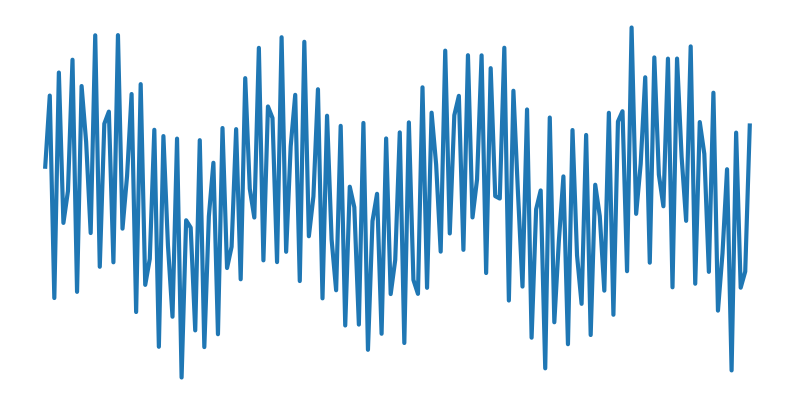

In [ ]:
x = [i for i in range(156)]
fig,ax = plt.subplots(figsize = (10,5))
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=20)
# plt.plot(x,gt_list[40],'-', label = 'ground truth',linewidth=3)
# plt.plot(x,outputs_test_t[40].squeeze().cpu().detach().numpy(),'-',label = 'DeepCorr',linewidth=3)
# plt.plot(x,func_denoised[40],'-', label = 'ground truth',linewidth=3)
# plt.legend(loc='upper right', prop={'size': 20})
# plt.plot(x,noise_list[40],'-',linewidth=3,)
plt.plot(x,observation_list[40],'-',linewidth=3)
plt.axis('off')
plt.savefig('drive/MyDrive/dataset/z+s_std=1/observation.png',transparent=True,dpi=500)

Text(0.5, 1.0, 'noise')

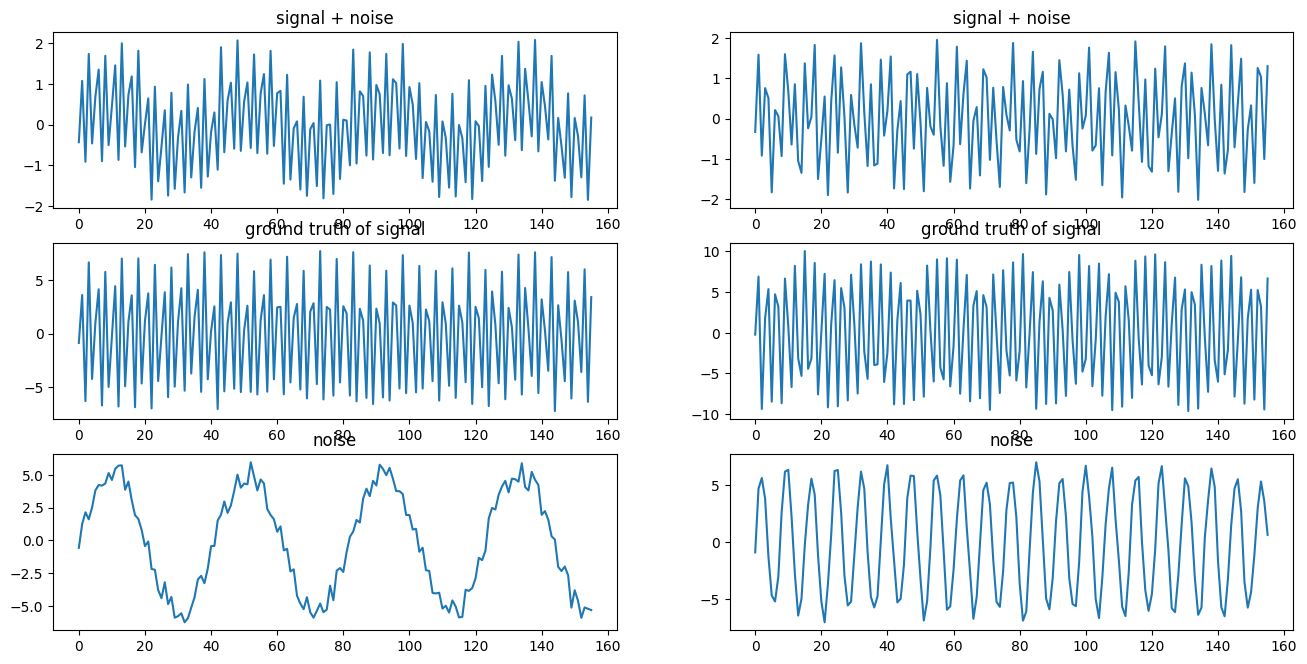

In [ ]:
x = [i for i in range(156)]
plt.figure(figsize = (16,16))
plt.subplot(6,2,1)
plt.plot(x,observation_list[900],'-')
plt.title('signal + noise')
plt.subplot(6,2,2)
plt.plot(x,observation_list[24],'-')
plt.title('signal + noise')
plt.subplot(6,2,3)
plt.plot(x,ground_truth_list[900],'-')
plt.title('ground truth of signal')
plt.subplot(6,2,4)
plt.plot(x,ground_truth_list[24],'-')
plt.title('ground truth of signal')
plt.subplot(6,2,5)
plt.plot(x,noise_list[900],'-')
plt.title('noise')
plt.subplot(6,2,6)
plt.plot(x,noise_list[24],'-')
plt.title('noise')

Text(0.5, 1.0, 'noise')

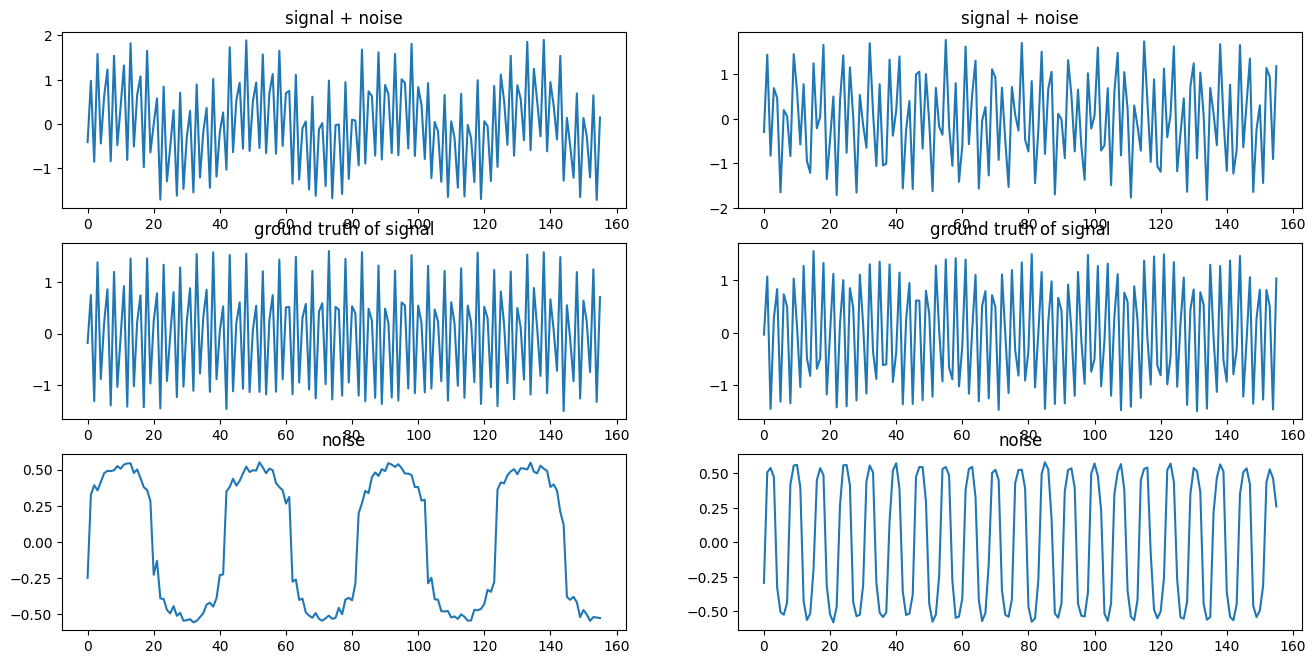

In [ ]:
x = [i for i in range(156)]
plt.figure(figsize = (16,16))
plt.subplot(6,2,1)
plt.plot(x,obs_list[900],'-')
plt.title('signal + noise')
plt.subplot(6,2,2)
plt.plot(x,obs_list[24],'-')
plt.title('signal + noise')
plt.subplot(6,2,3)
plt.plot(x,gt_list[900],'-')
plt.title('ground truth of signal')
plt.subplot(6,2,4)
plt.plot(x,gt_list[24],'-')
plt.title('ground truth of signal')
plt.subplot(6,2,5)
plt.plot(x,noise_c[900],'-')
plt.title('noise')
plt.subplot(6,2,6)
plt.plot(x,noise_c[24],'-')
plt.title('noise')

# DataLoader

In [ ]:
gt_list = np.loadtxt('drive/MyDrive/dataset/simulations/gt_list_z+c(s)_std=1.csv',
                 delimiter=",", dtype=float)
obs_list = np.loadtxt('drive/MyDrive/dataset/simulations/obs_list_z+c(s)_std=1.csv',
                 delimiter=",", dtype=float)
noi_list = np.loadtxt('drive/MyDrive/dataset/simulations/noi_list_z+c(s)_std=1.csv',
                 delimiter=",", dtype=float)

In [ ]:
import torch
class PathDataset(torch.utils.data.Dataset):
  def __init__(self, X, Y, Z):
    self.obs = X
    self.gt = Y
    self.noi = Z

  def __len__(self):
    return self.gt.shape[0]

  def __getitem__(self, index):
    ### noise is multiplied by a beta coefficient
    observation = self.obs[index]
    ground_truth = self.gt[index]
    noise = self.noi[index]
    s = 2*random.beta(4,4,1)
    noise_aug = s*noise

    return observation, ground_truth, noise_aug

In [ ]:
# initiate dataset in pytorch
inputs_all = PathDataset(obs_list,gt_list,noi_list)
generator = torch.Generator().manual_seed(42)
train_inputs, val_inputs, test_inputs = random_split(inputs_all, [0.7, 0.15, 0.15], generator=generator)

In [ ]:
# dataload
train_in = torch.utils.data.DataLoader(train_inputs, batch_size=64,
                                             shuffle=True, num_workers=1)
val_in = torch.utils.data.DataLoader(val_inputs, batch_size=len(val_inputs),
                                             shuffle=False, num_workers=1)
test_in = torch.utils.data.DataLoader(test_inputs, batch_size=len(test_inputs),
                                             shuffle=False, num_workers=1)

# cVAE model

In [ ]:
from typing import List, Callable, Union, Any, TypeVar, Tuple
# from torch import tensor as Tensor

Tensor = TypeVar('torch.tensor')

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F

class cVAE(nn.Module):


    def __init__(self,in_channels: int,latent_dim: int,hidden_dims: List = None) -> None:
        super(cVAE, self).__init__()

        self.latent_dim = latent_dim
        self.in_channels = in_channels
        self.hidden_dims = hidden_dims

        modules_z = []
        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 128]

        # Build Encoders
        for h_dim in hidden_dims:
            modules_z.append(
                nn.Sequential(
                    nn.Conv1d(in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm1d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        self.encoder_z = nn.Sequential(*modules_z)
        self.fc_mu_z = nn.Linear(hidden_dims[-1]*10, latent_dim)
        self.fc_var_z = nn.Linear(hidden_dims[-1]*10, latent_dim)

        modules_s = []
        in_channels = self.in_channels
        for h_dim in hidden_dims:
            modules_s.append(
                nn.Sequential(
                    nn.Conv1d(in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm1d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        self.encoder_s = nn.Sequential(*modules_s)
        self.fc_mu_s = nn.Linear(hidden_dims[-1]*10, latent_dim)
        self.fc_var_s = nn.Linear(hidden_dims[-1]*10, latent_dim)


        # Build Decoder
        modules = []

        self.decoder_input = nn.Linear(2*latent_dim, hidden_dims[-1] * 10)

        hidden_dims.reverse()


        for i in range(len(hidden_dims) - 1):
            if i//2==0:
                modules.append(
                    nn.Sequential(
                        nn.ConvTranspose1d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride = 2,
                                       padding=1,
                                       output_padding=1),
                        nn.BatchNorm1d(hidden_dims[i + 1]),
                        nn.LeakyReLU())
                )
            else:
                modules.append(
                    nn.Sequential(
                        nn.ConvTranspose1d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride = 2,
                                       padding=1,
                                       output_padding=0),
                        nn.BatchNorm1d(hidden_dims[i + 1]),
                        nn.LeakyReLU())
                )



        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
                            nn.ConvTranspose1d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=2,
                                               output_padding=1),
                            nn.BatchNorm1d(hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Conv1d(hidden_dims[-1], out_channels= 1,
                                      kernel_size= 3, padding= 1))

    def encode_z(self, input: Tensor) -> List[Tensor]:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes for noise
        """
        result = self.encoder_z(input)
        result = torch.flatten(result, start_dim=1)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu_z(result)
        log_var = self.fc_var_z(result)

        return [mu, log_var]

    def encode_s(self, input: Tensor) -> List[Tensor]:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes for signal
        """
        result = self.encoder_s(input)
        result = torch.flatten(result, start_dim=1)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu_s(result)
        log_var = self.fc_var_s(result)

        return [mu, log_var]

    def decode(self, z: Tensor) -> Tensor:
        """
        Maps the given latent codes
        onto the sequence space.
        """
        result = self.decoder_input(z)
        result = result.view(-1,128,10)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

    def reparameterize(self, mu: Tensor, logvar: Tensor) -> Tensor:
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward_tg(self, input: Tensor) -> List[Tensor]:
        """
        Forward the input to both encoder s and z and concatenate them
        """
        tg_mu_z, tg_log_var_z = self.encode_z(input)
        tg_mu_s, tg_log_var_s = self.encode_s(input)
        tg_z = self.reparameterize(tg_mu_z, tg_log_var_z)
        tg_s = self.reparameterize(tg_mu_s, tg_log_var_s)
        output = self.decode(torch.cat((tg_z, tg_s),1))
        return  [output, input, tg_mu_z, tg_log_var_z, tg_mu_s, tg_log_var_s,tg_z,tg_s]

    def forward_bg(self, input: Tensor) -> List[Tensor]:
        """
        Forward the input to both encoder s only and make another half of latent space 0s
        """
        bg_mu_s, bg_log_var_s = self.encode_s(input)
        bg_s = self.reparameterize(bg_mu_s, bg_log_var_s)
        zeros = torch.zeros_like(bg_s)
        output = self.decode(torch.cat((zeros, bg_s),1))
        return  [output, input, bg_mu_s, bg_log_var_s]

    def forward_fg(self, input: Tensor) -> List[Tensor]:
        """
        Forward the input to both encoder z only and make another half of latent space 0s
        """
        fg_mu_z, fg_log_var_z = self.encode_z(input)
        tg_z = self.reparameterize(fg_mu_z, fg_log_var_z)
        zeros = torch.zeros_like(tg_z)
        output = self.decode(torch.cat((tg_z, zeros),1))
        return  [output, input, fg_mu_z, fg_log_var_z]

    def loss_function(self,
                      *args,
                      ) -> dict:
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        """
        beta = 0.00001 # ratio of kl loss compared to reconstruction loss

        recons_tg = args[0]
        input_tg = args[1]
        tg_mu_z = args[2]
        tg_log_var_z = args[3]
        tg_mu_s = args[4]
        tg_log_var_s = args[5]
        tg_z = args[6]
        tg_s = args[7]
        recons_bg = args[8]
        input_bg = args[9]
        bg_mu_s = args[10]
        bg_log_var_s = args[11]

        recons_loss = F.mse_loss(recons_tg, input_tg)
        recons_loss += F.mse_loss(recons_bg, input_bg)

        kld_loss = 1 + tg_log_var_z - tg_mu_z ** 2 - tg_log_var_z.exp()
        kld_loss += 1 + tg_log_var_s - tg_mu_s ** 2 - tg_log_var_s.exp()
        kld_loss += 1 + bg_log_var_s - bg_mu_s ** 2 - bg_log_var_s.exp()
        kld_loss = torch.mean(-0.5 * torch.sum(kld_loss, dim = 1), dim = 0)

        loss = torch.mean(recons_loss + beta*kld_loss)
        return {'loss': loss, 'Reconstruction_Loss':recons_loss.detach(), 'KLD': kld_loss.detach()}

    def loss_function_val(self,
                      *args,
                      ) -> dict:
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        """
        beta = 0.00001 # ratio of kl loss compared to reconstruction loss

        recons_fg = args[0]
        input_fg = args[1]
        fg_mu_z = args[2]
        fg_log_var_z = args[3]

        recons_loss = F.mse_loss(recons_fg, input_fg)

        kld_loss = 1 + fg_log_var_z - fg_mu_z ** 2 - fg_log_var_z.exp()
        kld_loss = torch.mean(-0.5 * torch.sum(kld_loss, dim = 1), dim = 0)

        loss = torch.mean(recons_loss + beta*kld_loss)
        return {'val_loss': loss, 'val_recons_Loss':recons_loss.detach(), 'val_KLD': kld_loss.detach()}

    def sample(self,
               num_samples:int,
               current_device: int) -> Tensor:
        """
        Samples from the latent space and return the corresponding
        sequence space map.
        """
        z = torch.randn(num_samples,
                        self.latent_dim)
        z = z.to(current_device)
        samples = self.decode(z)
        return samples

    def generate(self, x: Tensor) -> Tensor:
        """
        Given an input sequence x, returns the reconstructed image
        """
        return self.forward_fg(x)[0]

In [ ]:
# initiate the model with intended latent space size
model = cVAE(1,16)

In [ ]:
model # model structure

cVAE(
  (encoder_z): Sequential(
    (0): Sequential(
      (0): Conv1d(1, 32, kernel_size=(3,), stride=(2,), padding=(1,))
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Conv1d(32, 64, kernel_size=(3,), stride=(2,), padding=(1,))
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Conv1d(64, 128, kernel_size=(3,), stride=(2,), padding=(1,))
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (3): Sequential(
      (0): Conv1d(128, 128, kernel_size=(3,), stride=(2,), padding=(1,))
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
  )
  (fc_mu_z): Linear(in_features=128

In [ ]:
# optimizer
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

In [ ]:
print(len(train_in))
print(len(val_in))
print(len(test_in))

110
1
1


# Training the Model

In [ ]:
def r_squared_list(x,y):
  # calculate the R-squared between each pair of sequences in two lists of sequences
  x_mean = np.repeat(np.reshape(x.mean(axis=1),(x.shape[0],1)),x.shape[1],axis=1)
  y_mean = np.repeat(np.reshape(y.mean(axis=1),(y.shape[0],1)),y.shape[1],axis=1)
  cov = (x-x_mean)*(y-y_mean)
  r_row = cov.sum(axis=1)/(x.std(axis=1)*y.std(axis=1)*x.shape[1])
  return np.square(r_row)

In [ ]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)
batch_size = 64
epoch_num = 200
train_loss_L = []
train_recons_L = []
train_KLD_L = []
val_loss_L = []
val_recons_L = []
val_KLD_L = []
test_correlation_L = []
test_loss_n_L = []
test_percentile_L = []
early_stopper = EarlyStopper(patience=10, min_delta=0.001)

for epoch in range(epoch_num):  # loop over the dataset multiple times
    print('Epoch {}/{}'.format(epoch, epoch_num-1))
    print('-' * 10)

    train_loss = 0.0
    train_reconstruction_loss = 0.0
    train_KLD = 0.0
    val_loss = 0.0
    val_reconstruction_loss = 0.0
    val_KLD = 0.0

    # Iterate over data.
    dataloader_iter_in = iter(train_in)
    for i in range(len(train_in)):
        inputs_gm,inputs_gt,inputs_cf = next(dataloader_iter_in)

        inputs_gm = inputs_gm.unsqueeze(1).float().to(device)
        inputs_cf = inputs_cf.unsqueeze(1).float().to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # encoder + decoder
        [outputs_gm, inputs_gm, tg_mu_z, tg_log_var_z, tg_mu_s, tg_log_var_s,tg_z,tg_x] = model.forward_tg(inputs_gm)
        [outputs_cf, inputs_cf, bg_mu_s, bg_log_var_s] = model.forward_bg(inputs_cf)
        outputs = torch.concat((outputs_gm,outputs_cf),1)
        loss = model.loss_function(outputs_gm, inputs_gm, tg_mu_z, tg_log_var_z, tg_mu_s, tg_log_var_s,tg_z,tg_x, outputs_cf, inputs_cf, bg_mu_s, bg_log_var_s)
        # backward + optimize
        loss['loss'].backward()
        optimizer.step()
        # print statistics
        train_loss += loss['loss']
        train_reconstruction_loss += loss['Reconstruction_Loss']
        train_KLD += loss['KLD']
    # validation
    with torch.no_grad():
        val_gm, val_gt, val_cf = next(iter(val_in))
        val_gm = val_gm.unsqueeze(1).float().to(device)
        val_cf = val_cf.unsqueeze(1).float().to(device)
        #[output_val, input_val, fg_mu_z, fg_log_var_z] = model.forward_fg(val_gm)
        #loss_val = model.loss_function_val(output_val, input_val, fg_mu_z, fg_log_var_z)
        [outputs_gm, inputs_gm, tg_mu_z, tg_log_var_z, tg_mu_s, tg_log_var_s,tg_z,tg_x] = model.forward_tg(val_gm)
        [outputs_cf, inputs_cf, bg_mu_s, bg_log_var_s] = model.forward_bg(val_cf)
        loss_val = model.loss_function(outputs_gm, inputs_gm, tg_mu_z, tg_log_var_z, tg_mu_s, tg_log_var_s,tg_z,tg_x, outputs_cf, inputs_cf, bg_mu_s, bg_log_var_s)
        if early_stopper.early_stop(loss_val['loss']):
            break

    epoch_train_loss = train_loss / (len(train_in)*2)
    epoch_train_reconstruction_loss = train_reconstruction_loss / (len(train_in)*2)
    epoch_train_KLD = train_KLD / (len(train_in)*2)
    epoch_val_loss = loss_val['loss']
    epoch_val_reconstruction_loss= loss_val['Reconstruction_Loss']
    epoch_val_KLD = loss_val['KLD']
    print('Training Loss: {:.4f} Training Reconstruction Loss: {:.4f} Training KLD {:.4f}'.format(epoch_train_loss, epoch_train_reconstruction_loss, epoch_train_KLD))
    print('Val Loss: {:.4f} Val Reconstruction Loss: {:.4f} Val KLD {:.4f})'.format(epoch_val_loss,epoch_val_reconstruction_loss,epoch_val_KLD))
    print('')
    print()
    train_loss_L.append(epoch_train_loss)
    train_recons_L.append(epoch_train_reconstruction_loss)
    train_KLD_L.append(epoch_train_KLD)
    val_loss_L.append(epoch_val_loss)
    val_recons_L.append(epoch_val_reconstruction_loss)
    val_KLD_L.append(epoch_val_KLD)

print('Finished Training')

test_gm, test_gt, test_cf = next(iter(test_in))
test_gm = test_gm.unsqueeze(1).float().to(device)
test_gt = test_gt.unsqueeze(1).float().to(device)
test_cf = test_cf.unsqueeze(1).float().to(device)
[output_test, input_test, fg_mu_z, fg_log_var_z] = model.forward_fg(test_gm)
loss_test = model.loss_function_val(output_test, input_test, fg_mu_z, fg_log_var_z)
print('Test Loss: {:.4f} Test Reconstruction Loss: {:.4f} Test KLD {:.4f})'.format(loss_test['val_loss'],loss_test['val_recons_Loss'],loss_test['val_KLD']))

Epoch 0/199
----------
Training Loss: 0.6351 Training Reconstruction Loss: 0.6342 Training KLD 83.2590
Val Loss: 0.6009 Val Reconstruction Loss: 0.5983 Val KLD 262.3578)


Epoch 1/199
----------
Training Loss: 0.2878 Training Reconstruction Loss: 0.2864 Training KLD 135.5368
Val Loss: 0.5475 Val Reconstruction Loss: 0.5448 Val KLD 274.7971)


Epoch 2/199
----------
Training Loss: 0.2674 Training Reconstruction Loss: 0.2660 Training KLD 139.2034
Val Loss: 0.5196 Val Reconstruction Loss: 0.5168 Val KLD 280.4122)


Epoch 3/199
----------
Training Loss: 0.2550 Training Reconstruction Loss: 0.2535 Training KLD 141.5418
Val Loss: 0.5018 Val Reconstruction Loss: 0.4989 Val KLD 287.0131)


Epoch 4/199
----------
Training Loss: 0.2456 Training Reconstruction Loss: 0.2442 Training KLD 142.4058
Val Loss: 0.4866 Val Reconstruction Loss: 0.4838 Val KLD 283.2293)


Epoch 5/199
----------
Training Loss: 0.2393 Training Reconstruction Loss: 0.2379 Training KLD 142.0598
Val Loss: 0.4835 Val Reconstruct

In [ ]:
torch.save(model.state_dict(), 'drive/MyDrive/dataset/simulations/model_z+s_std=1_run2')

In [ ]:
model = cVAE(1,16)
model.load_state_dict(torch.load('drive/MyDrive/dataset/simulations/model_z+c(s)_std=2_run3'))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)
test_gm, test_gt, test_cf = next(iter(test_in))
test_gm = test_gm.unsqueeze(1).float().to(device)
test_gt = test_gt.unsqueeze(1).float().to(device)
test_cf = test_cf.unsqueeze(1).float().to(device)
[output_test, input_test, fg_mu_z, fg_log_var_z] = model.forward_fg(test_gm)

In [ ]:
#output_test, input_test
output_scale = Scaler(output_test.squeeze().cpu().detach().numpy())
outputs_test_n = output_scale.transform(output_test.squeeze().cpu().detach().numpy())
test_r_squared_list = r_squared_list(test_gt.squeeze().cpu().detach().numpy(),outputs_test_n)
test_mean = test_r_squared_list.mean()
test_percentile= (np.percentile(test_r_squared_list,5), np.percentile(test_r_squared_list,95))

In [ ]:
print(test_mean)
print(test_percentile)
#print(early_stopper.counter)

0.74838674
(0.710708349943161, 0.7852807313203811)


# Show Training Result

In [ ]:
train_loss_L2 = [item.detach().cpu().numpy() for item in train_loss_L]
train_loss_L2 = np.array(train_loss_L2)
train_recons_L2 = [item.detach().cpu().numpy() for item in train_recons_L]
train_recons_L2 = np.array(train_recons_L2)
train_KLD_L2 = [item.detach().cpu().numpy() for item in train_KLD_L]
train_KLD_L2 = np.array(train_KLD_L2)

<ipython-input-57-1224d522e02f>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,3,1)


Text(0.5, 0, 'Epoches')

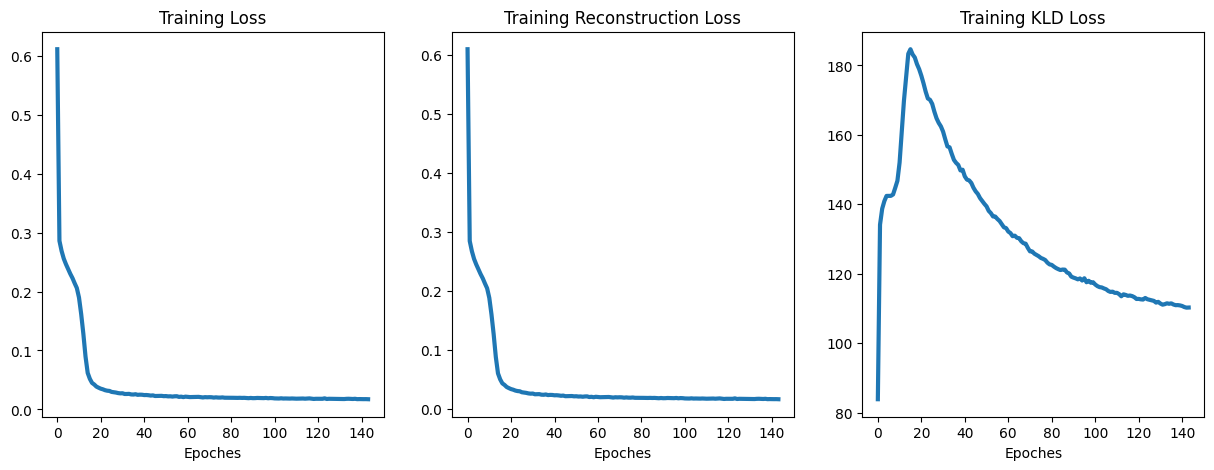

In [ ]:
num_list = [i for i in range(len(train_loss_L2))]
fig,ax = plt.subplots(figsize =(15,5))
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=20)
plt.subplot(1,3,1)
plt.plot(num_list,train_loss_L2, '-',linewidth=3)
plt.title('Training Loss')
plt.xlabel('Epoches')
plt.subplot(1,3,2)
plt.plot(num_list,train_recons_L2, '-',linewidth=3)
plt.title('Training Reconstruction Loss')
plt.xlabel('Epoches')
plt.subplot(1,3,3)
plt.plot(num_list,train_KLD_L2, '-',linewidth=3)
plt.title('Training KLD Loss')
plt.xlabel('Epoches')
# plt.savefig('drive/MyDrive/dataset/z+c(s)_std=2/training_loss.png',dpi=400)
# plt.savefig('drive/MyDrive/dataset/z+c(s)_std=2/training_rec_loss.png',dpi=400)
# plt.savefig('drive/MyDrive/dataset/z+c(s)_std=2/training_kld_loss.png',dpi=400)

In [ ]:
val_loss_L2 = [item.detach().cpu().numpy() for item in val_loss_L]
val_loss_L2 = np.array(val_loss_L2)
val_recons_L2 = [item.detach().cpu().numpy() for item in val_recons_L]
val_recons_L2 = np.array(val_recons_L2)
val_KLD_L2 = [item.detach().cpu().numpy() for item in val_KLD_L]
val_KLD_L2 = np.array(val_KLD_L2)

<ipython-input-59-85ef6725625f>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,3,1)


Text(0.5, 0, 'Epoches')

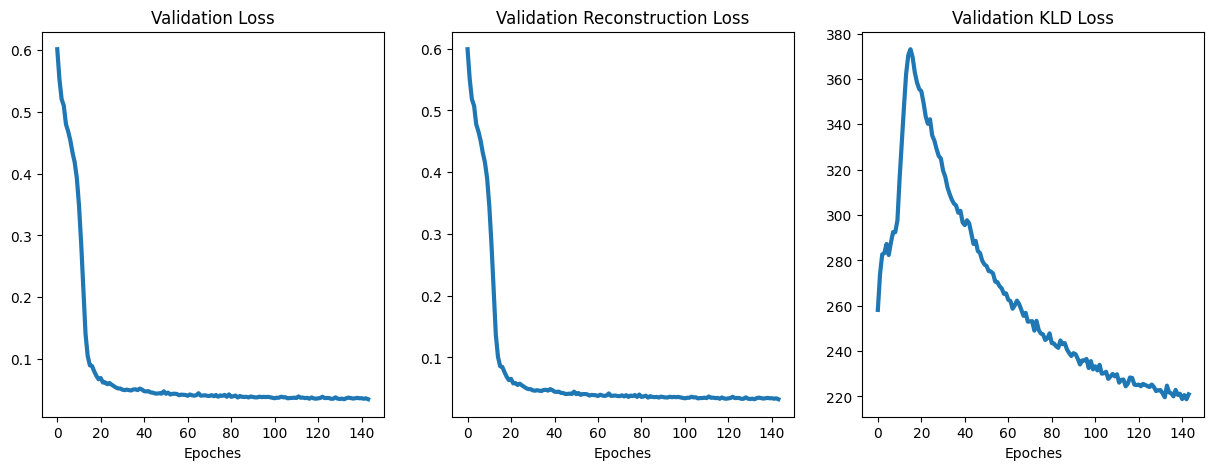

In [ ]:
num_list = [i for i in range(epoch_num)]
num_list = [i for i in range(len(train_loss_L2))]
fig,ax = plt.subplots(figsize =(15,5))
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=20)
plt.subplot(1,3,1)
plt.plot(num_list,val_loss_L2, '-',linewidth=3)
plt.title('Validation Loss')
plt.xlabel('Epoches')
plt.subplot(1,3,2)
plt.plot(num_list,val_recons_L2, '-',linewidth=3)
plt.title('Validation Reconstruction Loss')
plt.xlabel('Epoches')
plt.subplot(1,3,3)
plt.plot(num_list,val_KLD_L2, '-',linewidth=3)
plt.title('Validation KLD Loss')
plt.xlabel('Epoches')

# CompCorr


In [ ]:
dataloader_iter_in = iter(train_in)
train_gm,train_gt,train_cf = next(dataloader_iter_in)
for i in range(1,len(train_in)):
    train_gm_new,train_gt_new,train_cf_new = next(dataloader_iter_in)
    train_gm = np.concatenate((train_gm,train_gm_new),axis=0)
    train_cf = np.concatenate((train_cf,train_cf_new),axis=0)
print(train_gm.shape)
print(train_cf.shape)

(7000, 156)
(7000, 156)


In [ ]:
test_gm, test_gt,test_cf = next(iter(test_in))
test_gm = test_gm.numpy()
test_gt = test_gt.numpy()
test_cf = test_cf.numpy()

In [ ]:
from sklearn.decomposition import PCA
from sklearn import linear_model

# PCA likes the time dimension as first. Let's transpose our data.
train_gm_t = np.transpose(train_gm)
train_cf_t = np.transpose(train_cf)
test_gm_t = np.transpose(test_gm)
test_cf_t = np.transpose(test_cf)
# Fit PCA and extract PC timecourses
pca = PCA(n_components = 5)
pca.fit(train_cf_t)
#
confounds_pc = pca.fit_transform(test_cf_t)
confounds_pc.shape

(156, 5)

In [ ]:
# linear regression on each voxel: PCs -> voxel pattern
linear = linear_model.LinearRegression()
linear.fit(confounds_pc, test_gm_t)

# predict the activity of each voxel for this run
predict = linear.predict(confounds_pc)
func_denoised = test_gm_t - predict # t x v
func_denoised = np.transpose(func_denoised) # v x t
func_denoised.shape

(1500, 156)

In [ ]:
compcor_r_squared_list = r_squared_list(test_gt,func_denoised)
compcor_test_mean = compcor_r_squared_list.mean()
compcor_test_percentile= (np.percentile(compcor_r_squared_list,5), np.percentile(compcor_r_squared_list,95))

In [ ]:
print(compcor_test_mean)
print(compcor_test_percentile)

0.5495635563805368
(0.4588734099597474, 0.8587790878957426)


#Wilcoxon Test z+s std=1

In [ ]:
import scipy

In [ ]:
scipy.stats.wilcoxon(x=test_r_squared_list, y=compcor_r_squared_list,alternative='greater')

WilcoxonResult(statistic=1106203.0, pvalue=2.4893999978424223e-230)